# Context

Click-through rate (CTR) is a critical metric in digital marketing, representing the effectiveness of online advertisements in driving user engagement. Optimising CTR helps reduce customer acquisition costs and improve campaign ROI. Unlike traditional marketing methods, online campaigns are data-driven and scalable, allowing for advanced targeting strategies. [This dataset](https://www.kaggle.com/datasets/sk4467/email-ctr-prediction/code) contains data related to click-through-rates recorded for different email marketing campaigns, with the goal of predicting the CTR. ***My own personal objectives are rather Bayesian in nature, and are listed below.***

---

### Objectives and Key Questions (click to 'jump to' ↓)


#### 1. **Quantify the effect of campaign content and structure on click-through rate (CTR)**
- How do features like `subject_len`, `body_len`, `mean_paragraph_len`, and `no_of_CTA` influence CTR?
- What is the impact of elements like personalisation, images, urgency, or discount (`is_personalised`, `is_image`, `is_urgency`, or `is_discount`) on CTR?
- Are specific patterns, such as the use of different quotes or emoticons (`is_quote`, or `is_emoticons`), associated with higher or lower CTR?

---

#### 2. **Assess how product category and campaign topic interact with content features in shaping CTR**
- Do certain `category` or `product` types benefit more from personalisation or urgency cues?
- Are some `category` and content combinations (e.g., discounts, images, or timers) more effective?
- How does the interaction between `category` and elements like `no_of_CTA` or `is_price` affect performance?

---

#### 3. **Identify optimal times of day and days of week for ad performance**
- What `times_of_day` and `day_of_week` combinations yield the highest adjusted CTR?
- Is there a significant difference in CTR between weekends and weekdays (`is_weekend`)?
- How does time sensitivity (`is_urgency`) interact with `times_of_day` to impact CTR?

---

#### 4. **Estimate expected CTR for a new campaign based on its features**
- What is the expected CTR for a campaign with a given set of features (e.g., new `product`, `category`, or `sender`)?
- How robust are predictions for rarely seen products or categories?
- Can I predict CTR with credible intervals for new configurations not seen in training data?

---

#### 5. **Simulate CTR for content variations or new target audiences**
- How would changing one or more features (e.g., adding urgency or personalisation) affect CTR?
- What is the expected CTR if a successful ad is sent to a different `target_audience` segment?
- Can I identify high-potential `target_audience` and `category` combinations that are currently underused?

---

#### 6. **Examine campaign performance variability and uncertainty**
- Which campaigns or feature combinations show the most variability in predicted CTR?
- How much of the variation in CTR is attributable to content vs. timing vs. targeting?
- Which types of campaigns yield the most uncertain CTR predictions, and why?

---


**NOTE**: This entire analysis is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.

Let's connect! --> [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub.](https://github.com/munas-git)

# Importing Important Libraries

In [1]:
# data wrangling
import pandas as pd
from sklearn.preprocessing import StandardScaler

# non-bayesian numerical analysis
import math
import numpy as np
import scipy.stats as stats

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# bayesian modelling
import pymc as pm

# Handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [2]:
train_df = pd.read_csv('/kaggle/input/email-ctr-prediction/train_data.csv')
test_df = pd.read_csv('/kaggle/input/email-ctr-prediction/test_Data.csv')

train_df.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,...,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,...,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,...,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,...,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,...,0,0,1,0,0,0,0,0,14,0.142826


# Some EDA.

In [3]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
campaign_id,1888.0,944.500000,545.162973,1.0,472.750000,944.500000,1416.250000,1888.000000
sender,1888.0,4.395657,3.277927,0.0,3.000000,3.000000,3.000000,15.000000
subject_len,1888.0,86.246292,30.143206,9.0,69.000000,83.000000,98.000000,265.000000
body_len,1888.0,14185.780191,7327.615307,23.0,9554.500000,12689.000000,17351.500000,44491.000000
mean_paragraph_len,1888.0,35.239407,28.139498,4.0,21.000000,29.000000,40.000000,286.000000
day_of_week,1888.0,2.828390,1.763193,0.0,1.000000,3.000000,4.000000,6.000000
is_weekend,1888.0,0.199682,0.399867,0.0,0.000000,0.000000,0.000000,1.000000
category,1888.0,9.949682,5.300719,0.0,6.000000,10.000000,15.000000,15.000000
product,1888.0,17.525424,12.369526,0.0,9.000000,12.000000,27.250000,43.000000
no_of_CTA,1888.0,4.222458,4.628348,0.0,2.000000,3.000000,5.000000,49.000000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

**Observation**   
Asides the fact that `is_timer` is full of zeros, there doesn't seem to be any abnormalities within the data based on means and standard deviations of continuous variables, also no missing data thus, I’ll drop the entire `is_timer` column as it has no relevant information, I will the proceed with Pearson Correlation/ANOVA, and creating visualisations, before diving into today's main event: ***Bayesian modeling***. ✨

In [5]:
train_df.drop('is_timer', axis = 1, inplace = True)
test_df.drop('is_timer', axis = 1, inplace = True)

In [6]:
train_df.columns

Index(['campaign_id', 'sender', 'subject_len', 'body_len',
       'mean_paragraph_len', 'day_of_week', 'is_weekend', 'times_of_day',
       'category', 'product', 'no_of_CTA', 'mean_CTA_len', 'is_image',
       'is_personalised', 'is_quote', 'is_emoticons', 'is_discount',
       'is_price', 'is_urgency', 'target_audience', 'click_rate'],
      dtype='object')

## Pearson Correlation/ANOVA & Visualisations

In [7]:
# Idealy, I wouldn't have to manually specify them at this point because I could just use
# pandas select_dtypes but some categories have already been transformed to numerical
# values thus, I have to read through and specify.

continuous_var_cols = ['subject_len', 'body_len', 'mean_paragraph_len', 'no_of_CTA', 'mean_CTA_len']

categorical_cols = [column for column in train_df.columns if column not in continuous_var_cols
                      and column != 'click_rate']

### Pearson Correlation/ANOVA

In [8]:
print('Correlation scores of each continuous variable column with regards to "click_rate".')
train_df[continuous_var_cols + ['click_rate']].corr()['click_rate'][:-1]

Correlation scores of each continuous variable column with regards to "click_rate".


subject_len          -0.180143
body_len             -0.247866
mean_paragraph_len    0.178042
no_of_CTA            -0.172637
mean_CTA_len         -0.031162
Name: click_rate, dtype: float64

In [9]:
print('F-Static and p-values of each continuous variable column with regards to "click_rate".')

results = []

for col in categorical_cols:

    groups = [] 
    
    # all the sub-categories within current col
    unique_levels = train_df[col].unique()
    
    for level in unique_levels:
        # filter df to only include rates from rows within current level
        group_data = train_df[train_df[col] == level]['click_rate']

        # adding that data if each group level has at least 2 observations
        if len(group_data) >= 2:
            groups.append(group_data)

    # only compare if there are at least 2 groups
    if len(groups) >= 2:
        f_stat, p_value = stats.f_oneway(*groups)
        
        results.append({
            'categorical_column': col,
            'F_statistic': f'{f_stat:.3f}',
            'p_value': f'{p_value:.3f}'})


anova_results_df = pd.DataFrame(results).sort_values(by = 'p_value').reset_index().drop('index', axis = 1)
anova_results_df

F-Static and p-values of each continuous variable column with regards to "click_rate".


,categorical_column,F_statistic,p_value
0,sender,18.410,0.000
1,day_of_week,5.284,0.000
2,is_weekend,24.894,0.000
3,times_of_day,25.406,0.000
4,category,15.061,0.000
5,product,9.386,0.000
6,is_quote,4.517,0.000
7,is_emoticons,6.275,0.000
8,is_discount,14.087,0.000
9,is_urgency,24.959,0.000


**Observation**   
The *continuous variables* all have relatively weak-moderate +ve/-ve correlation with `click_rate`, no variables have very strong influence on the click through rates, at least as stand alone variables. Combining two or more through interaction terms might reveal some added info. Will explore later while modelling.

The *categorical variables* on the other have varying intensity of observed variance across their levels, each showing different degrees of relationship with the `click_rate`.

Since I have no real prior knowledge based on past data, and in order to avoid data leakagen I will be experimenting initially with weak priors around `Normal(mu = 0, sigma = 5)`, then I will gradually make adjustments based on what trace plots, and posterior predictive checks reveal.

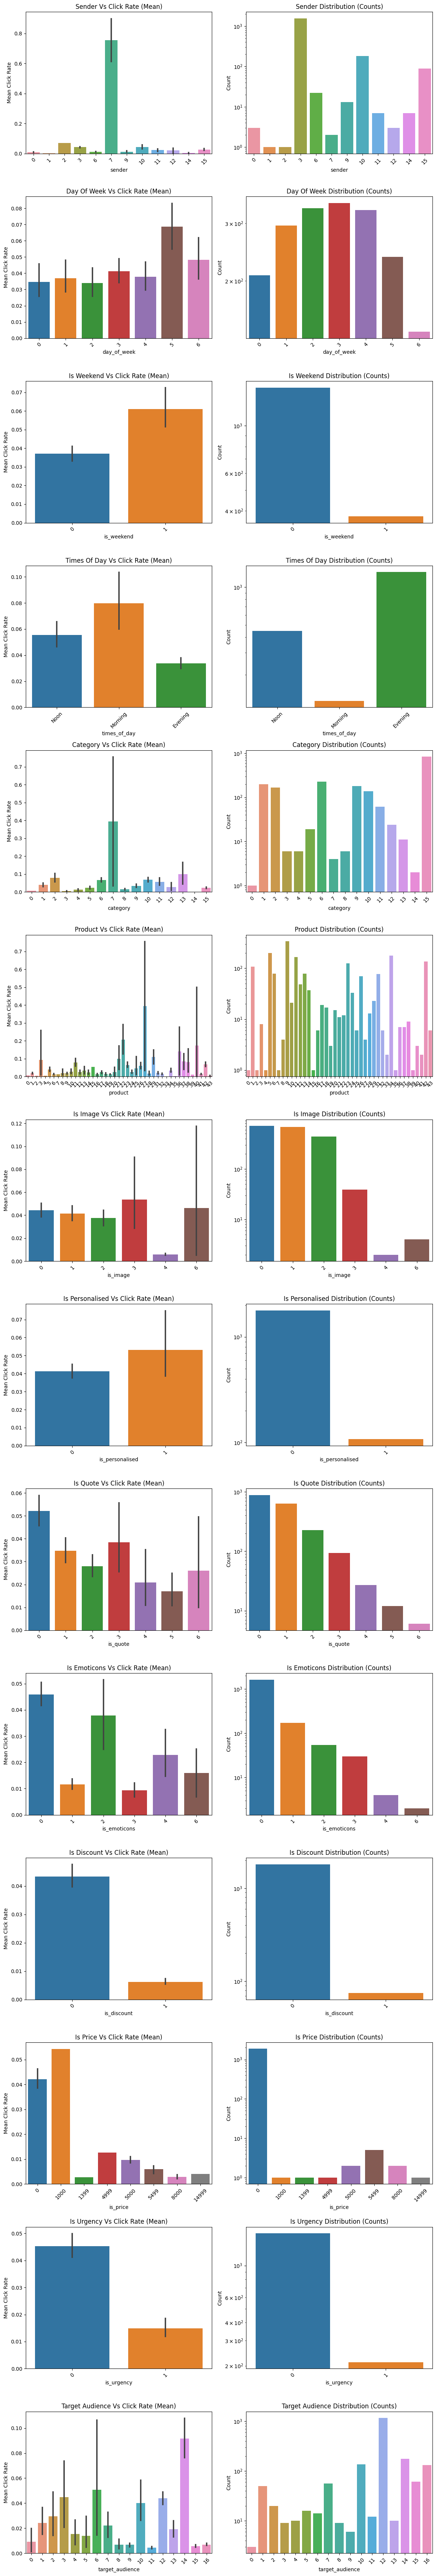

In [10]:
categorical_cols = categorical_cols[1:]  # excluding campaign_id column
num_plots = len(categorical_cols)
num_cols = 2
num_rows = len(categorical_cols)

plt.figure(figsize = (12, num_rows * 5))
for i, col in enumerate(categorical_cols):
    formatted_col = col.title().replace('_', ' ')
    
    # mean click rate
    plt.subplot(num_rows, num_cols, i * 2 + 1)
    sns.barplot(x = col, y = 'click_rate', data = train_df, estimator = np.mean)
    plt.title(f'{formatted_col} Vs Click Rate (Mean)')
    plt.ylabel('Mean Click Rate')
    plt.xticks(rotation = 45)

    # value counts
    plt.subplot(num_rows, num_cols, i * 2 + 2)
    plt.yscale('log')
    sns.countplot(x = col, data = train_df)
    plt.title(f'{formatted_col} Distribution (Counts)')
    plt.ylabel('Count')
    plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

**Observations**

It is very easy to assume that something like emails sent in the morning automatically means better click-through rates if you're only looking at the average click-through rates without considering how many mails were actually sent in the morning... For that reason, I represented the numbers of each category using log scales because some values are extremly small, leading to them basically being invisible on a regular scale.... ***With that said, these are my deductions:***

1. **sender**   
Based on click-through-rate, it looks like sender 1 has some command on the audience, leading to high click-through-rates but upon looking at the counts plot, it's clear that sender 1 only sent 2-3 mails so it's quite easy for click-through-rate to seem high if 2/3 clicked compared to 80/200 clicks.

2. **day_of_week**
Saturday seems to have had the highest click-through-rate however, not a relatively lower amount of mails were sent then, compared to the Monday-Friday.

3. **is_weekend**
Weekends seem to have better click-through-rate however, less emails were also sent over the weekend so that information isn't quite solid.

4. **time_of_day**   
Emails sent in the morning have the highest average click rate. However, the very few emails were actually sent in the morning thus, that information is misleading.

5. **category**   
A few specific categories show much higher click rates. However, these high-performing categories often had low email volume.

6. **product**   
Some products have notably higher click rates. However, these same seemingly high-performing products typically had lower representation in the email volume.

7. **is_image**   
Emails with image types 3 and 6 show a slightly higher average click rate. But then again, less of those image types were sent in mails.

8. **is_personalised**   
Personalised emails have a significantly higher click-through rate. However, they represent a low volume of emails sent.  

9. **is_quote**   
Quote category 0 was sent enough times, and also has the highest click-through-rate... People must really love the quote.

10. **is_emotions**   
Use of emoticon category 0 and 2 seem to have significant positive impact on click-through-rate, they were used faily often, and also have high click-through-rates.

11. **is_discount**   
Emails offering discounts seem to have performed worse in terms of click-through rate. However, these were also much lower discount mails sent... further analysis will reveal the true impact of diiscounts.

12. **is_price**
The datacard doesnt say what is_price means, so `I'm assuming these are price marks for products`. Based on that assumption, mails that advertise free products tend to have higher click-through rates. It is safe to assume this is valid because number of mails sent with that 0 price are also high, unlike price mark 1000.

13. **is_urgency**   
Emails with no sense of urgency achieved higher click-through rates. However, these types of emails were also more frequently compared to those with sence or urgency which seems to perform well even as few were sent.

14. **target_audience**
Target audience 14 responded much better than others. That particular audience also has a high volume of emails sent, so its effectieness could be vlid.


All that said, there's still a lot of information that can't be confidently inferred without more advanced modeling techniques. To address this, I will perform ***Multivariate Logistic Modeling*** using a ***Bayesian approach*** in order to incorporate prior knowledge, quantify uncertainty, and generate more robust probabilistic inferences about the factors influencing click behavior.

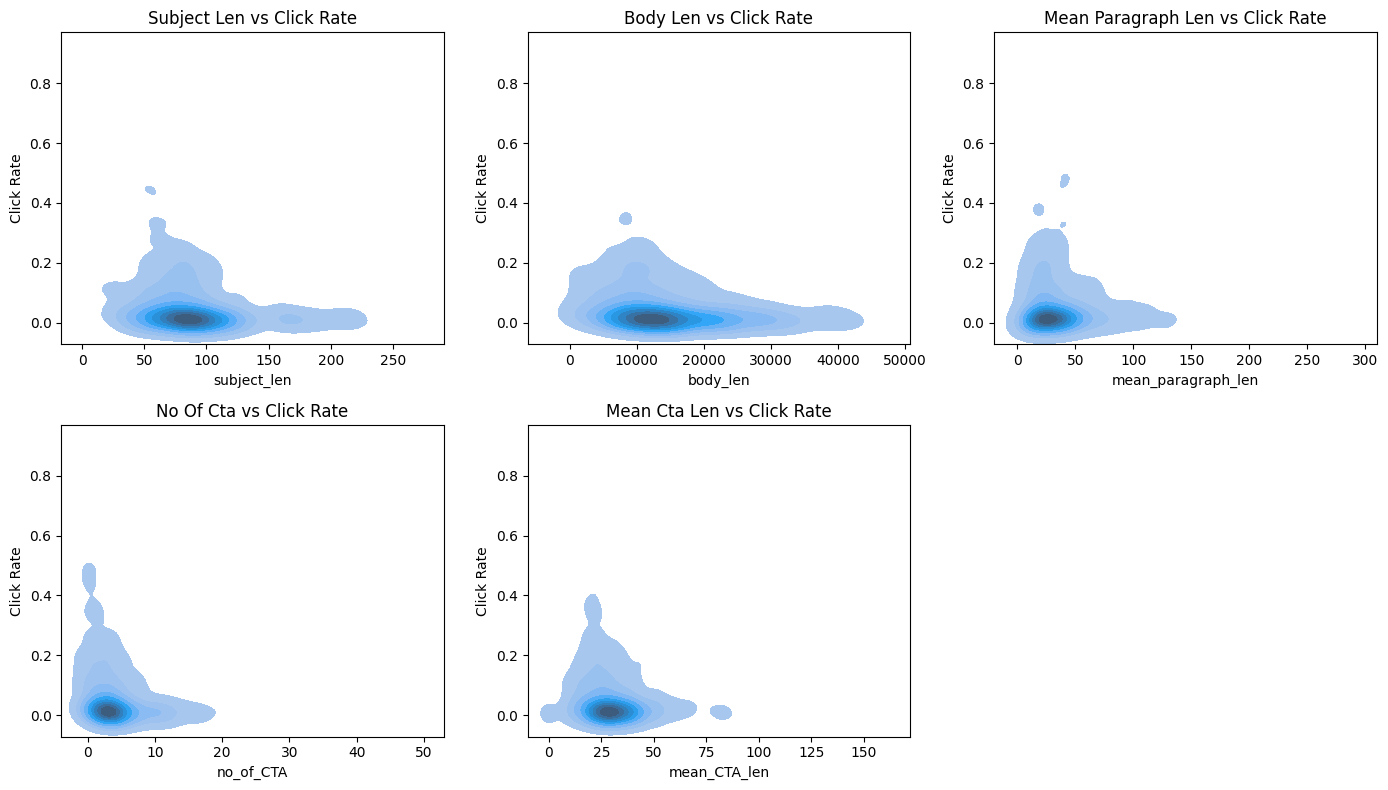

In [11]:
relevant_cols = continuous_var_cols + ['click_rate']
plt.figure(figsize = (14, 8))

for i, col in enumerate(continuous_var_cols):
    formatted_col = col.title().replace('_', ' ')
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(x = col, y = 'click_rate', data = train_df, fill = True)
    plt.title(f'{formatted_col} vs Click Rate')
    plt.xlabel(col)
    plt.ylabel('Click Rate')

plt.tight_layout()
plt.show()

1. **Subject Length**   
Subjects with 80-100 characters correlate with higher click-through-rates... `Probably because they are catchier and faster to read?`

3. **Body Length**
The highest click-through-rates occur with emails between 5,000-15,000 characters, with diminishing returns beyond 20,000. Very short emails under 5,000 characters perform poorly... `Guessing subscribers value substance?`

5. **Mean Paragraph Length**
Optimal paragraph length appears to be 25-50 characters, with click-through-rates dropping notably for paragraphs over 75 characters. `This confirms readers prefer scannable, digestible text blocks.`

7. **Number of CTAs**
1-5 Call(s) To Action yield the best performance, with a clear drop-off beyond 7-8... `This suggests that emails with just 1-5 strategic CTAs can outperform those with many scattered calls to action.` Maybe too much is overwhelming?

9. **Mean CTA Length**
CTAs between 15-30 characters seem to be the right lenght for to drive engagement. Notably, there's a small secondary peak around 75 characters... `could occasional longer call to actions work when well-crafted? Is it related to specific topics?`

# Bayesian Modelling

## Feature Engineering

In [12]:
time_of_day_map = {
    'Morning' : 0,
    'Noon' : 1,
    'Evening' : 2}

train_df['times_of_day'] = train_df['times_of_day'].map(time_of_day_map)
test_df['times_of_day'] = test_df['times_of_day'].map(time_of_day_map)

In [13]:
# train_df.columns

In [14]:
# with pm.Model() as ctr_model:
    